In [39]:
import os 
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [9]:
def read_voca_from_file(file_name):
    with open(file_name, 'r', encoding="ISO-8859-1") as f:
        content = f.readlines()
        content = [x.strip() for x in content] # remove newline chars 
        content = [x for x in content if x != ""] # remove empty words
        content = [x for x in content if x[0] not in [';', '+']] # remove invalid words
        content = [x for x in content if x[-1] not in [';', '+']] # remove invalid words
        
        return content
    
def load_glove_embeddings(path):
    embeddings = {}
    with open(path , 'r', encoding='utf-8') as f:
        for line in f:
            values = line.strip().split()
            w = values[0]
            vectors = np.asarray(values[1:], dtype='float32')
            embeddings[w] = vectors
    return embeddings

In [10]:
positive_words = read_voca_from_file("opinion-lexicon-English/positive-words.txt")
negative_words = read_voca_from_file("opinion-lexicon-English/negative-words.txt")

print("positive words: ", len(positive_words))
print("negative words: ", len(negative_words))

positive words:  2005
negative words:  4783


In [15]:
word_dict = load_glove_embeddings('glove.6B.50d.txt')

print("nr of loaded embeddings: ", len(word_dict))

nr of loaded embeddings:  400000


In [19]:
word = 'happy'
vector = word_dict[word] # if word is in word_dict
print("embedding of word", word, ":\n", vector)

embedding of word happy :
 [ 0.092086  0.2571   -0.58693  -0.37029   1.0828   -0.55466  -0.78142
  0.58696  -0.58714   0.46318  -0.11267   0.2606   -0.26928  -0.072466
  1.247     0.30571   0.56731   0.30509  -0.050312 -0.64443  -0.54513
  0.86429   0.20914   0.56334   1.1228   -1.0516   -0.78105   0.29656
  0.7261   -0.61392   2.4225    1.0142   -0.17753   0.4147   -0.12966
 -0.47064   0.3807    0.16309  -0.323    -0.77899  -0.42473  -0.30826
 -0.42242   0.055069  0.38267   0.037415 -0.4302   -0.39442   0.10511
  0.87286 ]


In [24]:
positive_word_embeddings = np.array([word_dict[w] for w in positive_words if w in word_dict])
negative_word_embeddings = np.array([word_dict[w] for w in negative_words if w in word_dict])

print("positive word embeddings: ", positive_word_embeddings.shape)
print("negative word embeddings: ", negative_word_embeddings.shape)

positive word embeddings:  (1893, 50)
negative word embeddings:  (4345, 50)


In [46]:
n = 1500

X_train = np.concatenate((positive_word_embeddings[:n], negative_word_embeddings[:n]), axis=0)
X_test = np.concatenate((positive_word_embeddings[n:], negative_word_embeddings[n:]), axis=0)

y_train = np.concatenate((np.ones(n), np.zeros(n)))
y_test = np.concatenate((np.ones(positive_word_embeddings[n:].shape[0]),
                         np.zeros(negative_word_embeddings[n:].shape[0])))

train_indices = np.random.permutation(X_train.shape[0])
# test_indices = np.random.permutation(X_test.shape[0])

X_train, y_train = X_train[train_indices], y_train[train_indices]
# X_test, y_test = X_test[test_indices], y_test[test_indices]

print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_test:", X_test.shape, "y_test:", y_test.shape)

X_train: (3000, 50) y_train: (3000,)
X_test: (3238, 50) y_test: (3238,)


In [56]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"),
    tf.keras.layers.Dense(50, activation="relu", kernel_initializer="he_normal"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model.compile(loss="binary_crossentropy", metrics="accuracy", optimizer=tf.keras.optimizers.Adam(lr=0.001))

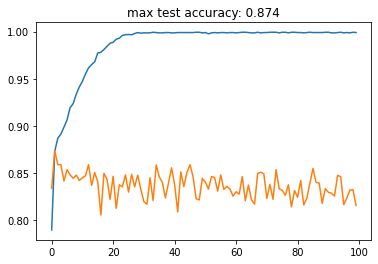

In [57]:
log = model.fit(X_train, y_train, batch_size=32, epochs=100, verbose=0, validation_data=(X_test, y_test))

plt.plot(log.history["accuracy"])
plt.plot(log.history["val_accuracy"])
plt.title(f"max test accuracy: {round(max(log.history['val_accuracy']), 3)}")
plt.show()

We see that the model overfitts the data but still reaches the expected test accuarcy of 85%. Maybe some regularization could push the test score.

In [69]:
positive_words_test = [w for w in positive_words if w in word_dict]
negative_words_test = [w for w in negative_words if w in word_dict]
positive_words_test = [w for w in positive_words_test if positive_words_test.index(w) >= n]
negative_words_test = [w for w in negative_words_test if negative_words_test.index(w) >= n]

print("positive test words:", len(positive_words_test), "negative test words:", len(negative_words_test))

test_words = positive_words_test + negative_words_test
print("total test words:", len(test_words))

positive test words: 393 negative test words: 2845
total test words: 3238


In [74]:
test_pred = model.predict(X_test)
test_word_predictions = [(test_words[i], y_test[i], test_pred[i][0]) for i in range(X_test.shape[0])]

In [101]:
positive_sorted = sorted(test_word_predictions, key=lambda x: x[-1], reverse=True)[:5]
negative_sorted = sorted(test_word_predictions, key=lambda x: x[-1], reverse=False)[:5]

for w, l, p in positive_sorted + negative_sorted:
    print(w)
    print("(", "positive" if l == 1 else "negative", ", prob=", round(p, 3), ")")
    print()

serene
( positive , prob= 1.0 )

serenity
( positive , prob= 1.0 )

sexy
( positive , prob= 1.0 )

shimmering
( positive , prob= 1.0 )

shine
( positive , prob= 1.0 )

lawlessness
( negative , prob= 0.0 )

infested
( negative , prob= 0.0 )

irresolvable
( negative , prob= 0.0 )

militancy
( negative , prob= 0.0 )

unrest
( negative , prob= 0.0 )



The positive as well as the negative examples seem to be very reasonable.

In [104]:
unsure = sorted(test_word_predictions, key=lambda x: abs(0.5 - x[-1]), reverse=False)[:5]

for w, l, p in unsure:
    print(w)
    print("(", "positive" if l == 1 else "negative", ", prob=", round(p, 3), ")")
    print()

inextricably
( negative , prob= 0.5 )

steal
( negative , prob= 0.5 )

foulness
( negative , prob= 0.503 )

freakishly
( negative , prob= 0.505 )

impede
( negative , prob= 0.507 )



All the top 5 most unsure examples seem to be negatively labled words. Their semtiment is also not very clear to me, e.g. `inextricably` can have both a negative or positive sentiment.

*Could you use the above system to make a polarity detection for the comments given by clients on products, e.g. on www.digitech.ch ?*

Yes in principle we could use it. In order to do that we could just calculate the predictions for each seperate word and then average the individual preditions into a global one.

*What would be the limitations of such system and how could we improve it ?*

Such a system would not be able to detect a context based sentiment of a word and hence cannot really detect the semtiment of a comment as a whole. This could be improved by using e.g. an RNN to classify whole text sections (comments) for a specific sentiment. This approach would also require the training data to be in Text2Label form.

*What is happening when a word is not in the dictionary of the embedding ?*

I guess there are different approaches
 - If some vocabulary words are not yet part of the used embedding space, we could just initialize them randomly and let the model learn it during the training. For this to be possible we need a lot of data.
 - We could learn the whole embedding space durring training. For this to be possible we would need even more data.
 - We could use n-grams based embeddings like FastText.
 - We could just neglect those words (which is what I did in this notebook).